In [1]:
import pandas as pd
import numpy as np
from datetime import date
import os
import json
import matplotlib.pyplot as plt

# Modelos
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

# Seaborn e MatplotLib | Graficos
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

RANDOM_SEED = 42

<center><img src="ml_lfcl.png"></center>


---
# 1. Data collection, Data Cleaning & Feature Engineering

### Método de **Feature Engineering** e **Limpeza de Dados**

Feature Engineering é o processo de usar conhecimento de domínio para extrair características de dados brutos por meio de técnicas de mineração de dados. Essas características podem ser usadas para melhorar o desempenho de algoritmos de aprendizagem automática.

In [2]:
def feature_engeneering(df):
    df_engineering = df.copy()


    df_engineering = df_engineering.drop_duplicates()
    
    df_engineering['hp'] = df['engine'].str.extract(r'(\d+\.?\d*)HP', expand=False).astype(float) #Cavalos
    df_engineering['liters'] = df['engine'].str.extract(r'(\d+\.?\d*)L\s', expand=False).astype(float)

    # --- Idade e Uso ---
    var_ano_atual = date.today().year
    df_engineering['car_age'] = var_ano_atual - df_engineering['model_year']
    df_engineering['car_age'] = df_engineering['car_age'].replace(0, 1)

    # --- Cilindrada ---
    df_engineering['cylinders'] = df['engine'].str.extract(r'(\d+)\s+Cylinder', expand=False)
    df_engineering['cylinders'] = df_engineering['cylinders'].fillna(df['engine'].str.extract(r'V(\d+)', expand=False))
    df_engineering['cylinders'] = df_engineering['cylinders'].astype(float)

    # --- Tecnologias de Motor ---
    df_engineering['is_turbo'] = df['engine'].str.contains(r'(?i)turbo', na=False).astype(int)
    df_engineering['turbo_type'] = df['engine'].str.extract(r'(Twin Turbo|Turbo)', expand=False)
    df_engineering['valve_train'] = df['engine'].str.extract(r'(DOHC|OHV|SOHC)', expand=False) 
    df_engineering['fuel_injection'] = df['engine'].str.extract(r'(PDI|GDI|MPFI)', expand=False)

    # --- Miles per year
    df_engineering['miles_p_year'] = df_engineering['milage'] / df_engineering['car_age']

    # --- FUEL TYPE ---
    def clean_fuel(val):
        s = str(val).lower()
        if 'hybrid' in s:
            return 'Hybrid'
        elif 'not supported' in s:
            return 'EV'
        else:
            return val
    df_engineering['fuel_type'] = df_engineering['fuel_type'].apply(clean_fuel)

    # --- TRANSMISSION TYPE ---
    def clean_transmission(val):
        s = str(val).lower()
        if 'automatic' in s or 'a/t' in s or 'cvt' in s:
            return 'Automatico'
        elif 'manual' in s or 'm/t' in s:
            return 'Manual'
        else:
            return 'Outro'

    df_engineering['transmission_type'] = df_engineering['transmission'].apply(clean_transmission)
    
    # --- Tratamento de Nulos ---
    df_engineering['clean_title'] = df_engineering['clean_title'].replace('Unknown', 'No') #Vazio passsa a ser "No"
    
    cols_texto = df_engineering.select_dtypes(include=['object']).columns
    df_engineering[cols_texto] = df_engineering[cols_texto].replace('-', 'Unknown').fillna('Unknown')

    # 1. Eficiência do motor
    # Evitar divisão por zero somando um valor ínfimo
    df_engineering['hp_per_liter'] = df_engineering['hp'] / (df_engineering['liters'] + 0.001)

    # 2. Rácio de Potência por Cilindro
    df_engineering['hp_per_cylinder'] = df_engineering['hp'] / (df_engineering['cylinders'] + 0.001)

    # 3. Quilometragem (Milage)
    df_engineering['milage'] = np.log(df_engineering['milage'])

    return df_engineering

#### 1º. Extração de Dados do Motor (REGEX)
---
Como a coluna $engine$ contém muita informação útil e varidaa, usamos "filtros" (Regex) para extrair apenas as diferentes features relevantes.

**HP e Litros**: Extraímos a potência (Cavalos) e a cilindrada (Litros).

**Cilindros**: Identificamos o número de cilindros (ex: V6, V8 ou 4 Cylinder).

#### 2º. Idade e Intensidade de Uso
---
Criamos variáveis que medem o "tempo de vida" do carro, pois um carro que faz muitos quilómetros num curto espaço de tempo costuma desvalorizar mais depressa.

**Idade do Carro**: Calculada subtraindo o ano do modelo ao ano atual.

**Milhas por Ano**: Dividimos a quilometragem total pela idade.

#### 3º. Tecnologias e Componentes
---
Identificamos características técnicas escondidas no texto do motor (coluna $engine$=, semelhante à realizada no 1º ponto.

**Turbo e Injeção:** Criamos colunas para saber se o carro é Turbo e o Tipo de Turbo, o tipo de válvulas (DOHC/SOHC) e o tipo de injeção de combustível.

#### 4º. Simplificação de Categorias
---
Agrupamos informações que estavam demasiado detalhadas ou "sujas", pois menos categorias ajudam o modelo a aprender padrões gerais em vez de se perder em detalhes irrelevantes

**Combustível**: Simplificamos para categorias como "Hybrid", "EV" ou o valor original, mas limpo.

**Transmissão**: Reduzimos dezenas de nomes para apenas "Automático", "Manual" ou "Outro".

#### 5º. Métricas de Eficiência
---
Criamos relações matemáticas entre as variáveis já existentes, ajudando o modelo a distinguir motores de alta performance de motores utilitários, mesmo que tenham a mesma cavalagem total.

**Potência Específica**: Calculamos $Cavalos por Litro$ e $Cavalos por Cilindro$.

#### 6º. Tratamento de Dados e Escala
---
Limpamos falhas e ajustamos os números para o modelo.

**Nulos e Placeholders**: Substituímos traços ("-") e valores vazios por "Unknown".

**Logaritmo na Quilometragem**: Aplicamos uma função matemática (log) na coluna milage, pois a quilometragem tem valores muito distantes entre si. O $log$ aproxima-os, tornando a aprendizagem do modelo mais estável e precisa

consegue meter o risco ate ao fim da linha apos o texto de cada capitulo?

In [3]:
# Recolha os Dados
df_treino = pd.read_csv('dados/train.csv', index_col='id')
df_teste = pd.read_csv('dados/test.csv', index_col='id')

print("✓ Dados lidos com Sucesso!")

✓ Dados lidos com Sucesso!


In [4]:
# Aplicar feature engineering e Limpeza de dados
df_treino_eng = feature_engeneering(df_treino)
df_teste_eng = feature_engeneering(df_teste)

print("✓ Feature Engineering Aplicado com Sucesso!")

✓ Feature Engineering Aplicado com Sucesso!


In [5]:
df_treino_eng.head(1)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,car_age,cylinders,is_turbo,turbo_type,valve_train,fuel_injection,miles_p_year,transmission_type,hp_per_liter,hp_per_cylinder
id,,,,,,,,,,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,12.269047,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,...,19,4.0,0,Unknown,Unknown,Unknown,11210.526316,Automatico,107.432854,42.989253


In [6]:
# Separar target
y = np.log(df_treino_eng['price'])
X = df_treino_eng
X_test = df_teste_eng.copy()

# Tipos de Features Relevantes para Previsao
features_numericas = ['hp', 'liters', 'car_age', 'cylinders', 'miles_p_year','milage', 'model_year', 'is_turbo']

# Criar dataset numérico
X_num = X[features_numericas].fillna(0)
X_test_num = X_test[features_numericas].fillna(0)

### **Enconding**: Tornar valores de texto/categoricos em numéricos

In [7]:
features_categoricas = ['brand', 'model', 'fuel_type', 'transmission_type', 
                           'clean_title', 'turbo_type', 'valve_train', 'fuel_injection','accident']

print("--- Valores Únicos por Coluna (Antes de Enconding) ---")
for col in features_categoricas:
    unicos = df_treino_eng[col].unique()
    print(f"\nColuna: {col} ({len(unicos)} valores)")
    print(unicos)

--- Valores Únicos por Coluna (Antes de Enconding) ---

Coluna: brand (57 valores)
['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

Coluna: model (1897 valores)
['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']

Coluna: fuel_type (7 valores)
['Gasoline' 'E85 Flex Fuel' 'Unknown' 'Hybrid' 'Diesel' '–' 'EV']

Coluna: transmission_type (3 valores)
['Automatico' 'Outro' 'Manual']

Coluna: clean_title (2 valores)
['Yes' 'Unknown']

Coluna: turbo_

In [8]:
# Preparar features Categoricas
X_cat = X[features_categoricas].copy().astype(str)
X_test_cat = X_test[features_categoricas].copy().astype(str)

X_cat = X_cat.replace('–', 'Unknown')
X_test_cat = X_test_cat.replace('–', 'Unknown')

# Encoding via Mapeamento (Pandas)
for col in features_categoricas:
    # Criar o dicionário baseado no treino: {valor: indice}
    # Ordenar alfabeticamente garante que o encoding seja consistente
    unique_values = sorted(X_cat[col].unique())
    mapping = {val: i for i, val in enumerate(unique_values)}
    
    # Aplicar no Treino
    X_cat[col] = X_cat[col].map(mapping)
    
    # Aplicar no Teste
    # .map() deixa NaN se o valor não existir no mapping. 
    # Usamos .fillna(-1) para novas categorias no teste.
    X_test_cat[col] = X_test_cat[col].map(mapping).fillna(-1).astype(int)

print("✓ Encoding Aplicado com Sucesso!")

✓ Encoding Aplicado com Sucesso!


In [9]:
for col in sorted(features_categoricas):
    unicos = sorted(X_cat[col].unique())
    
    contagem = len(unicos)
    primeiro = unicos[0]
    ultimo = unicos[-1]
    
    print(f"Coluna: {col}")
    print(f"   - Total de valores únicos: {contagem}")
    print(f"   - Intervalo: [{primeiro} ... {ultimo}]")

Coluna: accident
   - Total de valores únicos: 3
   - Intervalo: [0 ... 2]
Coluna: brand
   - Total de valores únicos: 57
   - Intervalo: [0 ... 56]
Coluna: clean_title
   - Total de valores únicos: 2
   - Intervalo: [0 ... 1]
Coluna: fuel_injection
   - Total de valores únicos: 4
   - Intervalo: [0 ... 3]
Coluna: fuel_type
   - Total de valores únicos: 6
   - Intervalo: [0 ... 5]
Coluna: model
   - Total de valores únicos: 1897
   - Intervalo: [0 ... 1896]
Coluna: transmission_type
   - Total de valores únicos: 3
   - Intervalo: [0 ... 2]
Coluna: turbo_type
   - Total de valores únicos: 3
   - Intervalo: [0 ... 2]
Coluna: valve_train
   - Total de valores únicos: 4
   - Intervalo: [0 ... 3]


In [10]:
# Concatenar features | Features a serem utilizadas para generalização
X_final = pd.concat([X_num, X_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

In [11]:
print(f" Dimensões de X_final: {X_final.shape[0]} amostras | {X_final.shape[1]} colunas")
print(f" Dimensões de X_test_final: {X_test_final.shape[0]} amostras | {X_test_final.shape[1]} colunas")

if list(X_final.columns) == list(X_test_final.columns):
    print("\n ✓ Colunas de Treino e Teste estão idênticas e alinhadas.")

final_features = X_final.columns.tolist()
print(f"\n ✓ Features a serem consolidadas: {final_features}")

 Dimensões de X_final: 188533 amostras | 17 colunas
 Dimensões de X_test_final: 125690 amostras | 17 colunas

 ✓ Colunas de Treino e Teste estão idênticas e alinhadas.

 ✓ Features a serem consolidadas: ['hp', 'liters', 'car_age', 'cylinders', 'miles_p_year', 'milage', 'model_year', 'is_turbo', 'brand', 'model', 'fuel_type', 'transmission_type', 'clean_title', 'turbo_type', 'valve_train', 'fuel_injection', 'accident']


Aqui fizemos a montagem final do dataset, depois de ter sido feito todo o pré-processoamento das variáveis, unificando para Treino e Teste as features categoricas transformadas com as que já eram numércias.

---
# 2. Model Training & Evaluation

### Método de **Definição dos Modelos** - Dicionário com objetos dos modelos de previsão.

In [12]:
def obter_modelos():
    modelos = {
        'Linear Regression': LinearRegression(),

        #'KNN': KNeighborsRegressor(),

        #'Decision Tree': DecisionTreeRegressor(random_state= RANDOM_SEED),

        #'Random Forest': RandomForestRegressor(random_state= RANDOM_SEED, n_jobs=-1),

        #'XGBoost': xgb.XGBRegressor(random_state= RANDOM_SEED, n_jobs=-1),

        #'MLP Regressor': MLPRegressor(random_state= RANDOM_SEED, early_stopping=True),
    }

    return modelos

### Métodos para **"GridSearchCV"** - Otimização de Hipérparametrso

A **Otimização de Hiperparâmetros, ou Hyperparameter Tuning em ingles**, é o processo de encontrar as melhores configurações para um modelo de Machine Learning, ajustando-as sistematicamente para otimizar o seu desempenho, precisão e capacidade de generalização. Os hiperparâmetros são definidos externamente antes da aprendizagem começar, servindo como o "manual de instruções" que molda o comportamento do algoritmo.

Para cada modelo, é definida uma grelha de valores para os hiperparâmetros pretendidos e, posteriormente, com a ajuda de Cross Validation (Validação Cruzada), o modelo é testado em diferentes subconjuntos de dados. No caso do GridSearchCV, o sistema executa uma pesquisa exaustiva, realizando todas as combinações possíveis da grelha para identificar qual delas maximiza uma métrica de desempenho específica, neste caso o RMSE (Root Mean Squared Error).

In [13]:
def obter_params_grid(nome_modelo):
    grids = {
        'Linear Regression': {
            'fit_intercept': [True, False],
            'copy_X': [True, False],
            'n_jobs': [-1],
            'positive': [True, False]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 11],            
            'weights': ['uniform', 'distance'],
            'p': [1, 2]                         # 1=Manhattan, 2=Euclidean
        },
        'Decision Tree': {
            'max_depth': [3, 5, 8, 12],
            'min_samples_split': [10, 20, 40],
            'min_samples_leaf': [5, 10, 20],
            'criterion': ['squared_error']
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'XGBoost': {
            'n_estimators': [900, 1000, 1100],      
            'learning_rate': [0.01, 0.01, 0.1],
            'max_depth': [2, 3, 4],
            '
        },
        'MLP Regressor': {
            'hidden_layer_sizes': [(50,50,50), (100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'alpha': [0.0001, 0.05],
        }
    }
    return grids.get(nome_modelo, {})

#### **1º | Linear Regression**: procura ajustar uma linha reta para descrever a relação entre duas variáveis: uma independente ($X$) e uma dependente ($Y$). Dos mais rápidos a executar entre os escolhidos, e também dos menos capaz de generalizar.

<center><img src="https://rasbt.github.io/mlxtend/user_guide/regressor/LinearRegression_files/simple_regression.png" width=45% height=45%><em><br>Exemplo de 'Linear Regression'.</em></center>

A equação da linha é:

$$\hat{y} = \beta_0 + \beta_1 x$$

* **$W_0$**: Intercepto (valor de $Y$ quando $X = 0$)
* **$W_1$**: Inclinação (variação de $Y$ por cada unidade de $X$)

O objetivo é minimizar a soma dos quadrados das diferenças entre os valores observados e os previstos (Método dos Mínimos Quadrados):

$$\text{Erro} = \sum (y_i - \hat{y}_i)^2$$

#### Interpretação:
* **$W_1 > 0$**: Relação positiva (quando $X$ aumenta, $Y$ também aumenta).
* **$W_1 < 0$**: Relação negativa (quando $X$ aumenta, $Y$ diminui).
* **$W_1 \approx 0$**: Pouca ou nenhuma relação linear entre as variáveis.

#### Hiperparametros:
- **fit_intercept**: Decide se o modelo deve calcular o ponto onde a linha corta o eixo Y.
  
- **positive**: Força os coeficientes a serem positivos. É útil para previsões de preços de carros, onde não faz sentido certas características diminuírem o valor de forma irrealista.

- **copy_X**: Decide se o modelo deve trabalhar numa cópia dos dados ou nos originais. Mais a ver com a eficiência de memória e integridade dos dados originais durante o treino.

---

#### **2º | K-Neighbors Regressor**: Baseia-se na proximidade entre amostras vizinhas.

<center><img src="https://towardsdatascience.com/wp-content/uploads/2022/05/1jz9WO8NRWHlVx7qLtN88MQ.png" width=50% height=50%><em><br>Exemplo de 'KNN'.</em></center>

- **n_neighbors**: O número de "vizinhos" que o modelo consulta para dar uma resposta.. Escolhemos valores impares ([3, 5, 11])de forma a evitar empates; Começamos com 3 (muito sensível) e vamos até 11 (mais estável e genérico).
  
<center><img src="https://mlarchive.com/wp-content/uploads/2022/09/img2-3-1024x585.png" width=30% height=30%></center>

- **weights**: Define a influência de cada vizinho na decisão. Testa se a proximidade absoluta é mais importante que a simples contagem de vizinhos.

<center><img src="https://i.sstatic.net/gAILq.png" width=30% height=30%></center>

-  **metric**: Define a fórmula para calcular a distância entre pontos, testando se a distância deve ser medida "em linha reta" (euclideana) ou em "quarteirões/grelha" (manhantan).
<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20241112152015029347/KNN_DISTANCES-660.jpg" width=30% height=30%></center>

---
#### **3º | Decision Tree**: funciona como um fluxograma de perguntas lógicas .

<center><img src="https://www.jeremyjordan.me/content/images/2017/03/Screen-Shot-2017-03-11-at-10.15.37-PM.png" width=50% height=50%> <em><br>Exemplo de 'Decision Tree'.</em>
</center>

- **max_depth**: Determina a profundidade máxima da árvore. $[3, 5, 8, 12]$: Evita que a árvore cresça infinitamente e "decore" o dataset (overfitting).
- **min_samples_split**: Define o número mínimo de amostras necessárias para que um nó se divida em dois.$[10, 20, 40]$: Valores altos forçam a árvore a tomar decisões baseadas em grupos grandes de dados, ignorando exceções/ruído.
-  **min_samples_leaf**: Mínimo de amostras que cada "folha" final deve conter. $[5, 10, 20]$: Garante que nenhuma previsão seja baseada em apenas 1 ou 2 casos isolados, tornando o modelo mais robusto.

<center><img src="https://substackcdn.com/image/fetch/$s_!KOpK!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F378b4e1c-32e5-4184-8bdd-78228eb6bfe2_1087x383.png" width=35% height=35%></center>

---
#### **4º | Random Forest**: funciona como coleção de árvores de decisão que votam entre si .

<center><img src="https://miro.medium.com/v2/resize:fit:1400/0*Ga2SY3cwKnkCRCTZ.jpg" width=50% height=50%> <em><br>Exemplo de 'Random Forest'.</em>
</center>

- **n_estimators**: O número de árvores na floresta. $[100, 200, 300]$: 100 é o padrão; 300 oferece mais estabilidade. Mais árvores reduzem a variância do erro.
- **max_depth**: A profundidade de cada árvore individual..$[10, 20]$: Como é uma floresta, as árvores podem ser mais profundas que numa árvore isolada, pois a média final compensa erros individuais.
-  **min_samples_leaf**: Mínimo de amostras que cada "folha" final deve conter. $[1, 2, 4]$: Valores baixos permitem que a floresta capture detalhes mais finos sem perder a generalização do conjunto.

<center><img src="https://substackcdn.com/image/fetch/$s_!KOpK!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F378b4e1c-32e5-4184-8bdd-78228eb6bfe2_1087x383.png" width=35% height=35%></center>

---
#### **5º | XGBOOST**: baseia-se em criar árvores de forma sequencial, onde cada nova árvore tenta corrigir os erros das anteriores.

<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20250521100554969405/XG-Boost.webp" width=50% height=50%> <em><br>Exemplo de 'XG Boost'.</em>
</center>

- **n_estimators**: Cada árvore adicional tenta refinar a previsão do modelo. $[900, 1000, 1100]$: Estes são valores considerados elevados. A utilização de cerca de 1000 árvores indica que o objetivo é extrair o máximo de detalhe possível dos dados. Como o dataset é complexo um número alto de estimadores permite que o modelo convirja para uma solução mais precisa, desde que seja acompanhado por uma taxa de aprendizagem baixa para evitar que o modelo aprenda "depressa demais" e cometa erros..
  
- **learning_rate**: Controla a magnitude da contribuição de cada nova árvore para a previsão final. $[0.01, 0.1]$: O valor 0.01 é utilizado para um ajuste fino e conservador. Ele garante que o modelo avance em passos muito pequenos, o que é ideal para evitar o overfitting (sobreajuste) e garantir a estabilidade.


-  **max_depth**: Limita o crescimento vertical de cada árvore individual. $[2, 3, 4]$: Valores baixos como 2, 3 ou 4 forçam cada árvore a ser muito simples, sendo que força do modelo vem da combinação de mil árvores simples, em vez de poucas árvores complexas. Isto resulta num modelo final com muito mais capacidade de generalizar para novos dados de teste.

---
#### **6º | MLP Regressor**: funciona como coleção de árvores de decisão que votam entre si .

<center><img src="https://www.researchgate.net/profile/Dominique_Guerillot3/publication/314106922/figure/fig11/AS:653106945724416@1532724238105/Example-of-multilayer-perceptron-with-two-hidden-layers.png" width=40% height=40%> <em><br>Exemplo de 'MLP Regressor'.</em>
</center>

- **hidden_layer_sizes**: Define a arquitetura da rede (quantas camadas e quantos neurónios). $[(50,50,50), (100,)]$: Testa uma rede "profunda" (3 camadas de 50) contra uma rede "larga" e simples (1 camada de 100).
  
- **activation**: A função matemática que decide se o neurónio "dispara".$['tanh', 'relu']$: relu é o padrão moderno de alta performance; tanh é uma alternativa clássica que pode funcionar melhor em certos dados de regressão.
  
-  **alpha**: Parâmetro de regularização (penaliza pesos demasiado grandes). $[0.0001, 0.05]$: Controla a complexidade da rede. Um alpha maior (0.05) impede que a rede neurais se torne demasiado complexa e "viciada".

In [14]:
def executar_grid_search(modelo, nome, X_train, y_train, X_val, y_val):
    print(f"\n A iniciar GridSearch para : {nome}")
    
    # Obter a grelha de parâmetros para o modelo específico
    param_grid = obter_params_grid(nome) 
    
    grid_search = GridSearchCV(
        estimator=modelo,
        param_grid=param_grid,
        cv=3,
        scoring='neg_root_mean_squared_error',
        verbose=3,
        n_jobs=-1
    )

    # Executar o treino com procura exaustiva
    grid_search.fit(X_train, y_train)
    melhor_modelo = grid_search.best_estimator_

    # 2. Avaliação dos resultados
    y_pred_train = melhor_modelo.predict(X_train)
    y_pred_val = melhor_modelo.predict(X_val)

    # Cálculo do RMSE (Root Mean Squared Error)
    rmse_train = root_mean_squared_error(y_train, y_pred_train)
    rmse_val = root_mean_squared_error(y_val, y_pred_val)

    print(f"\n======== {nome} ========")
    print(f"Melhores Parâmetros: {grid_search.best_params_}")
    print(f"\n▶ RMSE Treino: {rmse_train:.4f}")
    print(f"\n▶ RMSE Validação: {rmse_val:.4f}")

    return {
        'nome': nome,
        'rmse_train': rmse_train,
        'rmse_val': rmse_val,
        'modelo_treinado': melhor_modelo
    }

### Método com **Grafico de Dispersao** (Visualizacao de Previsao vs Real)

In [15]:
def grafico_dispersao(nome_modelo, modelo_obj, X_val, y_val, usar_scaled_viz=False, X_val_scaled=None, ax=None):
    # 1. Gerar previsões
    if usar_scaled_viz:
        y_pred = modelo_obj.predict(X_val_scaled)
    else:
        y_pred = modelo_obj.predict(X_val)

    # 2. Garantir que temos um eixo para desenhar
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # 3. Plotar com Seaborn
    sns.scatterplot(x=y_val, y=y_pred, ax=ax, alpha=0.6, s=40, color='royalblue', label='Previsões')
    
    # 4. Linha de Perfeição (y = x)
    lims = [y_val.min(), y_val.max()]
    ax.plot(lims, lims, color='red', linestyle='--', lw=2, label='Regressor ')

    # 5. Estética do gráfico
    ax.set_title(f'Previsões vs Real - {nome_modelo}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valor Real (log)', fontsize=10)
    ax.set_ylabel('Valor Previsto (log)', fontsize=10)
    ax.legend(loc='upper left', frameon=True)
    ax.grid(True, alpha=0.3)

---

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=RANDOM_SEED)

Esta função baralha os dados aleatoriamente antes de dividir, garantindo que o modelo não aprenda uma sequência específica de linhas, mas sim padrões reais.
Define que **20% dos dados serão guardados para validação** e os outros **80% serão usados para o treino**. Não precisamos de criar um divisão para test pois os dados ja formam fornecidos em Treino e Teste

#### Normalizar dados (importante para KNN e MLP) | Permite que todas as features contribuam equilibradamente para o modelo

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

# Alinhar as colunas do conjunto de teste com as colunas usadas no treino
# (mesma ordem; preencher colunas em falta com 0)
X_test_aligned = X_test_final.reindex(columns=X_train.columns, fill_value=0)

X_test_scaled = scaler.fit_transform(X_test_aligned)

O $StandardScaler$ transformar os valores em escalas de desvio (Z-score) impedindo que variáveis com grandes amplitudes (como a quilometragem) "ofusquem" variáveis cruciais mas de pequena escala (como a cilindrada ou o rácio HP/Litro). Num algoritmo como KNN que utiliza tipicamente a distância Euclidiana para comparar amostras, torna a normalização indispensável. Sem ela, variáveis com grandes magnitudes (como a Quilometragem) dominam o cálculo, tornando as de pequena escala (como a Cilindrada) irrelevantes.

**Distância Euclideana**: $$d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + \dots + (p_n - q_n)^2}$$

Por exemplo, supondo que que estamos a comparar dois carros usando apenas a Quilometragem e a Cilindrada (Litros):
- Carro A: 100.000 km | 2.0 Litros
- Carro B: 101.000 km | 5.0 Litros

Ao calcular a distância:
- Diferença nos KM: $(101.000 - 100.000)^2 = 1.000.000$
- Diferença nos Litros: $(5.0 - 2.0)^2 = 9$
- Distância Total: $\sqrt{1.000.000 + 9} \approx 1000.004$

Uma diferença de 1.000 km impacta a fórmula em 1.000.000, enquanto uma diferença de 3L no motor impacta apenas 9. Como resultado, o modelo "ignora" a potência e considera carros muito diferentes como se fossem vizinhos idênticos.

Quando aplicamos StandardScaler, transformas ambas as colunas para a mesma escala (Média 0, Desvio 1).
A quilometragem passa a variar, por exemplo, entre -2 e 2.
A cilindrada passa a variar, por exemplo, entre -2 e 2.

In [18]:
print("="*50)
print("RESUMO DA DIVISÃO DOS DADOS (TRAIN-TEST SPLIT)\n")

print(f"Conjunto de TREINO:     {X_train.shape[0]} amostras (80%)")
print(f"Conjunto de VALIDAÇÃO:  {X_val.shape[0]} amostras (20%)")
print("-" * 50)
print(f"Total de Features:      {X_train.shape[1]} colunas")
print(f"Target (Preço):          {y_train.name if hasattr(y_train, 'name') else 'y'}")

# Verificação consistência
if X_train.shape[0] + X_val.shape[0] == X_final.shape[0]:
    print("\n✓- Integridade dos dados confirmada.")
else:
    print("\nX - O número de amostras não coincide com o original.")
print("="*50)

RESUMO DA DIVISÃO DOS DADOS (TRAIN-TEST SPLIT)

Conjunto de TREINO:     150826 amostras (80%)
Conjunto de VALIDAÇÃO:  37707 amostras (20%)
--------------------------------------------------
Total de Features:      17 colunas
Target (Preço):          price

✓- Integridade dos dados confirmada.


### Treino de Modelos

In [19]:
modelos = obter_modelos()

#Treinar os modelos e Avaliar
resultados = []
modelos_treinados = {}

for nome, modelo in modelos.items():
    # Decidir se usar dados normalizados
    usar_scaled = nome in ['KNN', 'SVR Linear', 'MLP Small']

    # Executar Grid Search para tuning
    if usar_scaled:
        X_t = X_train_scaled
        X_v = X_val_scaled
    else:
        X_t = X_train
        X_v = X_val
        
    res = executar_grid_search(modelo, nome, X_t, y_train, X_v, y_val)

    resultados.append(res)
    modelos_treinados[nome] = {
        'modelo': res['modelo_treinado'],
        'usar_scaled': usar_scaled
    }


 A iniciar GridSearch para : Linear Regression
Fitting 3 folds for each of 8 candidates, totalling 24 fits

======== Linear Regression ========
Melhores Parâmetros: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}

▶ RMSE Treino: 0.5481

▶ RMSE Validação: 0.5523


Utilizamos o **gridsearchCV** do scikit-learn de forma a otimizar e escolher os melhores hiperparametros para o modelo. Recebe uma grelha de valores para diferentes parametros para cada algoritmo, testa todas as combinações entre esses e valores e para cada combinação, através de cross-validation, divide os dados em conjuntos $'folds'$, treinando em alguns e testando noutros. Desta forma, garantimos que o resultado não foi sorte mas consistência estatistica.

#### **Grafico de Dispersao** - Gera uma grelha de subplots para comparar visualmente o desempenho de todos os modelos treinados, facilitando a identificação do algoritmo com melhor ajuste à linha de perfeição.

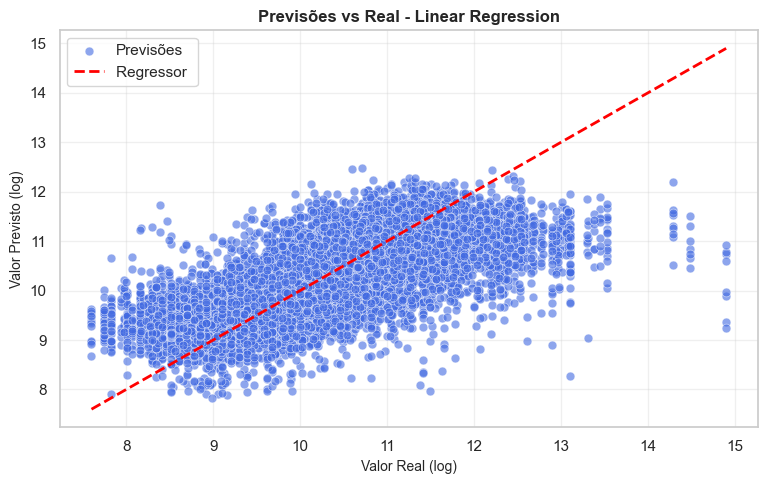

In [20]:
n_modelos = len(modelos_treinados)
n_cols = 2
n_rows = (n_modelos + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

axes_flat = np.atleast_1d(axes).ravel()

for idx, (nome_modelo, info_modelo) in enumerate(modelos_treinados.items()):
    grafico_dispersao(
        nome_modelo=nome_modelo,
        modelo_obj=info_modelo['modelo'],
        X_val=X_val,
        y_val=y_val,
        usar_scaled_viz=info_modelo['usar_scaled'],
        X_val_scaled=X_val_scaled,
        ax=axes_flat[idx]
    )

# Remover subplots vazios (caso o número de modelos seja ímpar)
for idx in range(n_modelos, len(axes_flat)):
    fig.delaxes(axes_flat[idx])

plt.tight_layout()
plt.show()

In [21]:
# Comparação final
print(f"\n\n{'='*80}")
print(" ■ COMPARAÇÃO DE MODELOS (ordenados por RMSE de validação)")
print(f"{'='*80}\n")

# Criar o DataFrame com os resultados
df_resultados = pd.DataFrame(resultados)

df_resultados = df_resultados.sort_values('rmse_val', ascending=True)

print(df_resultados[['nome', 'rmse_val']].to_string(index=False))

# Melhor modelo
melhor_resultado = df_resultados.iloc[0]

print(f"\n\n ▶ MELHOR MODELO: {melhor_resultado['nome']}")
print(f"   RMSE Validação: {melhor_resultado['rmse_val']:,.4f}")



 ■ COMPARAÇÃO DE MODELOS (ordenados por RMSE de validação)

             nome  rmse_val
Linear Regression  0.552294


 ▶ MELHOR MODELO: Linear Regression
   RMSE Validação: 0.5523


---
# 3. Salvar Submissão & Fazer Log do Modelo

### Método para **guardar log das configurações do modelo** - Esta função automatiza o salvamento dos resultados. Gera um ficheiro de submissão numerado e atualiza um log central contendo as métricas de erro e os hiperparâmetros utilizados, garantindo que cada experiência seja documentada e reprodutível.

In [22]:
def salvar_submissao_log(df_sub, modelo_treinado, nome_modelo, metricas):
    pasta = 'submissoes'
    os.makedirs(pasta, exist_ok=True)

    # Descobrir o próximo ID de submissão
    ficheiros = os.listdir(pasta)
    ids_existentes = []
    for f in ficheiros:
        if f.startswith('submission_') and f.endswith('.csv'):
            if f == "Historico_Resultados.csv": continue
            try:
                numero_str = f.replace('submission_', '').replace('.csv', '')
                ids_existentes.append(int(numero_str))
            except ValueError:
                continue
    
    next_id = max(ids_existentes) + 1 if ids_existentes else 1
    
    nome_arquivo_sub = f"submission_{next_id}.csv"
    path_csv_submissao = os.path.join(pasta, nome_arquivo_sub)
    path_log_geral = os.path.join(pasta, "Historico_Resultados.csv")

    # Salvar submissão
    df_sub.to_csv(path_csv_submissao, index=False)

    # Extrair Hiperparâmetros
    try:
        params = modelo_treinado.get_params()
    except:
        params = {"info": "Não foi possível extrair params"}

    
    dados_log = {
        "id_submissao": next_id,
        "ficheiro_submissao": nome_arquivo_sub,
        "Algoritmo": metricas['nome'],        
        "Treino RMSE": metricas['rmse_train'],
        "Validação RMSE": metricas['rmse_val'],
        "hiperparametros": str(params)
    }
        
    df_novo_registo = pd.DataFrame([dados_log])

    if os.path.exists(path_log_geral):
        df_novo_registo.to_csv(path_log_geral, mode='a', header=False, index=False)
    else:
        df_novo_registo.to_csv(path_log_geral, index=False)

    print(f"\n✓ Submissão #{next_id} finalizada!")
    print(f" ▱ Ficheiro de submissão: {path_csv_submissao}")
    print(f" ▱ Histórico atualizado em: {path_log_geral}")

In [23]:
# Obter dados do melhor modelo do DataFrame de resultados
melhor_modelo_nome = melhor_resultado['nome']
melhor_modelo = modelos_treinados[melhor_modelo_nome]['modelo']
usar_scaled = modelos_treinados[melhor_modelo_nome]['usar_scaled']

# Escolher o conjunto de teste correto
X_test_usar = X_test_scaled if usar_scaled else X_test_aligned

# Fazer previsões
pred_log = melhor_modelo.predict(X_test_usar)


pred_reais = np.exp(pred_log) 

# Criar DataFrame de submissão
df_submissao = pd.DataFrame({
    'id': df_teste.index,
    'price': pred_reais
})

# Criar a submissão
salvar_submissao_log(df_submissao, melhor_modelo, melhor_modelo_nome, melhor_resultado.to_dict())


✓ Submissão #2 finalizada!
 ▱ Ficheiro de submissão: submissoes\submission_2.csv
 ▱ Histórico atualizado em: submissoes\Historico_Resultados.csv
